In [81]:
#필요한 라이브러리 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [82]:
#사용할 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [83]:
#이미지들의 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [84]:
#train과 val에 있는 데이터를합친 후 8:2로 분할해 다시 할당
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [85]:
#train데이터프레임에 정상과 폐렴데이터 수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [86]:
#tf.data 인스턴스를 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [87]:
#데이터셋의 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [88]:
#폐렴이면 True, 노말이면 False를 리턴하는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [89]:
#이미지의 데이터타입과 사이즈를 변경
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [90]:
#process_path함수에서 get_label와 decode_img를 실행
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [91]:
#train 데이터 셋과 validation 데이터 셋을 만들어 process_path적용후 저장
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [92]:
#train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만든다
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [93]:
#학습 데이터를 효율적으로 사용할 수 있도록 데이터를 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # shuffle()을 사용하며 고정 크기 버퍼를 유지,무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # repeat()를 사용하면 여러 번 데이터셋을 사용할 수 있게 한다
    ds = ds.batch(BATCH_SIZE) # batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다
    ds = ds.prefetch(buffer_size=AUTOTUNE) # prefetch()를 사용하면 학습 데이터를 나눠서 읽어온다, 리소스의 유휴 상태를 줄일 수 있습니다
    return ds

train_ds = prepare_for_training(train_ds) # train_ds에 적용
val_ds = prepare_for_training(val_ds) # val_ds에 적용

In [94]:
#Convolution block틀을 만든다
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [95]:
#Dense Block틀을 만든다
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate) # Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용
    ])
    
    return block

In [96]:
#CNN모델 구조를 만든다.
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [97]:
#데이터가 imbalance하기 때문에 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하는 Weight balancing를 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [98]:
#GPU를 선택, 모델은 만들어둔build_model을 선택
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 두 개밖에 없기 때문에 binary_crossentropy
        metrics=METRICS
    )

In [99]:
#모델fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 64s 210ms/step - loss: 0.4034 - accuracy: 0.7936 - precision: 0.9510 - recall: 0.7619 - val_loss: 0.6190 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 205ms/step - loss: 0.2193 - accuracy: 0.9109 - precision: 0.9750 - recall: 0.9035 - val_loss: 1.4325 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1904 - accuracy: 0.9277 - precision: 0.9792 - recall: 0.9225 - val_loss: 0.2057 - val_accuracy: 0.9192 - val_precision: 0.9019 - val_recall: 0.9987
Epoch 4/10
261/261 [==============================] - 54s 207ms/step - loss: 0.1539 - accuracy: 0.9432 - precision: 0.9838 - recall: 0.9392 - val_loss: 0.1391 - val_accuracy: 0.9433 - val_precision: 0.9822 - val_recall: 0.9398
Epoch 5/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1576 - accura

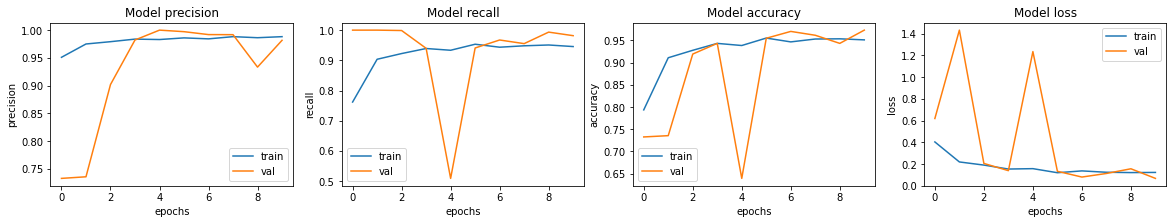

In [100]:
#그래프로 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [101]:
#loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 0.8163 - accuracy: 0.7853 - precision: 0.7490 - recall: 0.9872
Loss: 0.8163009285926819,
Accuracy: 0.7852563858032227,
Precision: 0.7490272521972656,
Recall: 0.9871794581413269


In [102]:
#렌덤하게 좌우반전하는 함수
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [103]:
#좌우반전 함수적용

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [104]:
#좌우 반전 적용 모델fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 212ms/step - loss: 0.1387 - accuracy: 0.9485 - precision: 0.9856 - recall: 0.9447 - val_loss: 0.1297 - val_accuracy: 0.9500 - val_precision: 0.9917 - val_recall: 0.9396
Epoch 2/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1194 - accuracy: 0.9559 - precision: 0.9877 - recall: 0.9527 - val_loss: 0.2338 - val_accuracy: 0.9375 - val_precision: 0.9213 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 208ms/step - loss: 0.1549 - accuracy: 0.9425 - precision: 0.9841 - recall: 0.9379 - val_loss: 0.1816 - val_accuracy: 0.9375 - val_precision: 0.9255 - val_recall: 0.9948
Epoch 4/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1280 - accuracy: 0.9490 - precision: 0.9859 - recall: 0.9450 - val_loss: 0.0982 - val_accuracy: 0.9596 - val_precision: 0.9918 - val_recall: 0.9528
Epoch 5/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1213 - accura

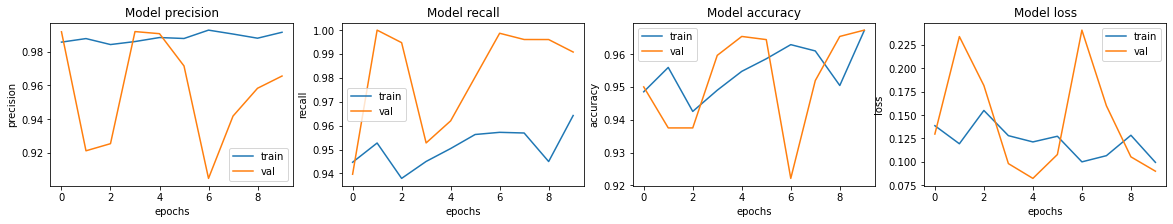

In [105]:
#그래프로 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [106]:
#loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 1.3454 - accuracy: 0.7548 - precision: 0.7190 - recall: 0.9974
Loss: 1.3453787565231323,
Accuracy: 0.754807710647583,
Precision: 0.7190388441085815,
Recall: 0.9974358677864075


In [107]:
#모델 구조 변경
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(1024, 0.6),
        dense_block(512, 0.6),
        dense_block(256, 0.5),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [108]:
#모델 변경 후 실핼

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 두 개밖에 없기 때문에 binary_crossentropy
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 209ms/step - loss: 0.6813 - accuracy: 0.6305 - precision: 0.8492 - recall: 0.6124 - val_loss: 0.5806 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 208ms/step - loss: 0.3640 - accuracy: 0.8436 - precision: 0.9548 - recall: 0.8292 - val_loss: 0.8740 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 208ms/step - loss: 0.3085 - accuracy: 0.8695 - precision: 0.9689 - recall: 0.8519 - val_loss: 0.8604 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 207ms/step - loss: 0.2980 - accuracy: 0.8795 - precision: 0.9614 - recall: 0.8733 - val_loss: 0.1865 - val_accuracy: 0.9327 - val_precision: 0.9613 - val_recall: 0.9462
Epoch 5/10
261/261 [==============================] - 55s 210ms/step - loss: 0.2571 - accura

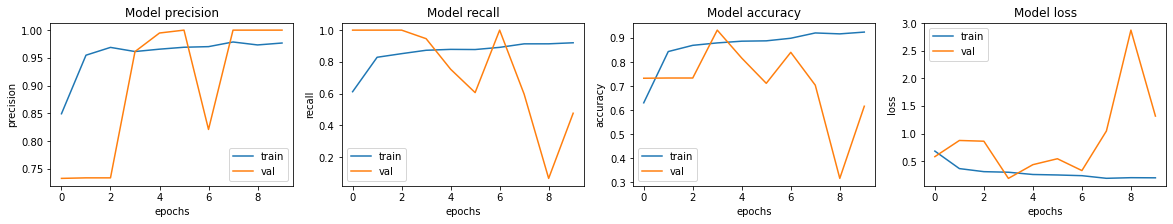

In [109]:
#그래프로 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [110]:
#loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 120ms/step - loss: 1.0938 - accuracy: 0.6683 - precision: 0.9507 - recall: 0.4949
Loss: 1.0938161611557007,
Accuracy: 0.6682692170143127,
Precision: 0.9507389068603516,
Recall: 0.4948717951774597


In [111]:
#Convolution block틀을 만든다
def conv_block(x, filters, strides=1):
    #skip Connection용 데이터 빼두기
    shortcut = x
    
    #첫번째 컨볼루션 층
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    #두번째 컨볼루션 층
    x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    #전과 다르면 shortcut변경
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    #skip Connection적용
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    
    
    return x

In [112]:
#Resnet-18 형태
inputs=tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#초기 컨볼루션 및 풀링
x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

#Residual Stage
x = conv_block(x, 64)
x = conv_block(x, 64)

x = conv_block(x, 128, strides=2)
x = conv_block(x, 128)

x = conv_block(x, 256, strides=2)
x = conv_block(x, 256)

x = conv_block(x, 512, strides=2)
x = conv_block(x, 512)

# Global average pooling과 outputs출력
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [113]:
with tf.device('/GPU:0'):
    model = model

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 두 개밖에 없기 때문에 binary_crossentropy
        metrics=METRICS
    )
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 205ms/step - loss: 0.3334 - accuracy: 0.8774 - precision: 0.9603 - recall: 0.8713 - val_loss: 3.9374 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1573 - accuracy: 0.9413 - precision: 0.9802 - recall: 0.9402 - val_loss: 2.7031 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1401 - accuracy: 0.9456 - precision: 0.9849 - recall: 0.9416 - val_loss: 1.3308 - val_accuracy: 0.7337 - val_precision: 0.7331 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1089 - accuracy: 0.9574 - precision: 0.9890 - recall: 0.9533 - val_loss: 0.5608 - val_accuracy: 0.8365 - val_precision: 0.8185 - val_recall: 0.9987
Epoch 5/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1162 - accura

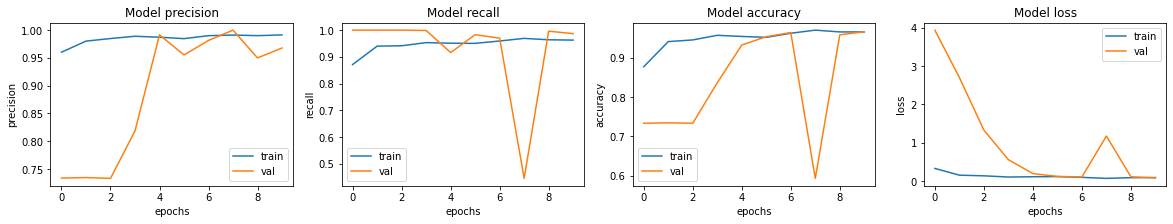

In [114]:
#그래프로 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [115]:
#loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 1.1602 - accuracy: 0.7532 - precision: 0.7185 - recall: 0.9949
Loss: 1.160157561302185,
Accuracy: 0.7532051205635071,
Precision: 0.7185184955596924,
Recall: 0.9948717951774597


# CNN기반 베이스 모델  
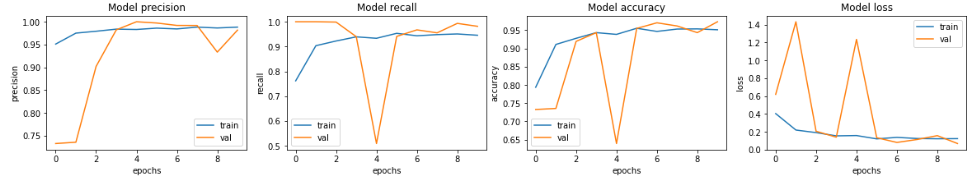  
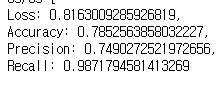  
# 데이터 augmentation기법을 사용
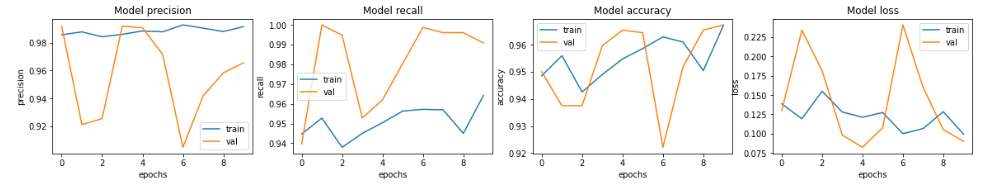  
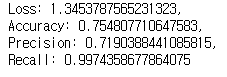  
# 모델 구조변경 이후
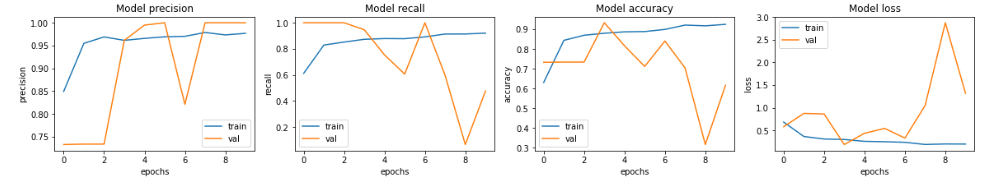  
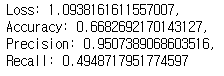  
# ResNet-18모델 적용
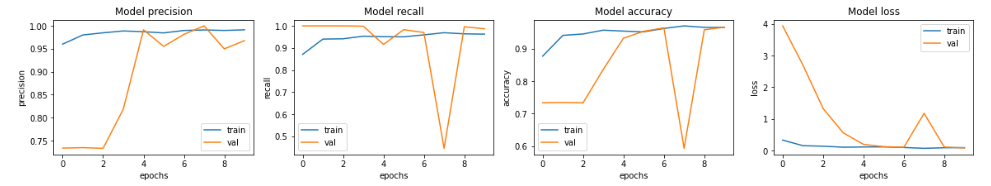  
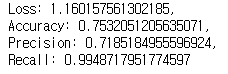  
회고: 처음모델에서 구조를 변경해도 정확도가 올라가지는 않았다. 하지만 augmentation기법과 ResNet-18모델 적용한건 Recall이 높아졌다.  
    그리고 모델 구조변경이후에는 모델의 정밀도가 크게 올랐다. 정확도를 올리고 싶었는데 정확도는 오르지 않아서 아쉬웠다.